# 1. Set Up

In [1]:
!spack find -lvp tfel
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
mvfpqw7 tfel@4.0.0+abaqus+ansys+aster+calculix+castem+comsol+cyrano+diana-fea+europlexus~fortran~ipo~java+lsdyna~python~python_bindings build_system=cmake build_type=Release generator=make  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
==> 1 installed package
/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib


In [2]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh
# from scipy import optimize
# from scipy.optimize import curve_fit, least_squares

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import mesh_create as mshcrte
import custom_models as cm
import utils as ut
import plotting


# def set_display_configurations(): pass
#     # from matplotlib.colors import ListedColormap
#     # pv.set_plot_theme("document")

#     # plt.rcParams['figure.figsize'] = [12, 9]
#     # plt.rcParams['figure.dpi'] = 300
#     # plt.rcParams['font.family'] = "DejaVu Serif"
#     # plt.rcParams['font.size'] = 20

#     # from pyvirtualdisplay import Display
#     # display = Display(backend="xvfb", visible=False, size=(800, 600))
#     # display.start()
    
# set_display_configurations()
    


# 2. Log paths and meta

In [3]:
def days_since_epoch():
    epoch_date = time.strptime("2024-08-17", "%Y-%m-%d")
    epoch_seconds = time.mktime(epoch_date)
    # Get the current time
    current_seconds = time.time()
    # Calculate days since the epoch
    days_since_epoch = int((current_seconds - epoch_seconds) // (24 * 3600))
    return days_since_epoch

def log_sim_entry(params):
    params.global_log_file = params.wk_dir / "simulations/simulation_log.json"
    
    # Load existing logs if the log file exists
    if params.global_log_file.exists():
        with open(params.global_log_file, 'r') as f:
            logs = json.load(f)
    else:
        logs = {}

    # Create the params dictionary for the log entry
    params_dict = {
        "mesh": mode,
        "pile_manager": params.pile_manager.model_dump(serialize_as_any=True),
        "box_manager": params.box_manager.model_dump(serialize_as_any=True),
        "prescribed_force": params.prescribed_force.model_dump() if getattr(params, 'prescribed_force', None) else None,
        "prescribed_disp": params.prescribed_disp.model_dump() if getattr(params, 'prescribed_disp', None) else None,
    }

    # Filter simulations for today and count simulations with the same parameters
    params.prior_sims_with_same_params = [log for log in logs.values() if log['params'] == params_dict]
    # params.prior_sims_with_same_params_no = len(params.prior_sims_with_same_params)
    # params.new_sim_number_with_same_params = params.prior_sims_with_same_params_no + 1
    params.new_sim_number = len(logs) + 1
    # Determine simulation number for today prior to this simulation
    params.prior_sims_today = len([log for log in logs.values() if log['date_of_sim'] == params.date_of_sim])
    params.new_sim_number_today = params.prior_sims_today + 1

    # Create the log entry as a dictionary
    log_entry = {
        "days_since_epoch": params.days_since_epoch,
        "sim_number_of_the_day": params.new_sim_number_today,
        "date_of_sim": params.date_of_sim,
        "time_of_sim": params.time_of_sim,
        # "sim_number_with_same_params": params.new_sim_number_with_same_params,
        "params": params_dict,
    }

    # Add the new entry to the logs
    logs[f"{params.new_sim_number}"] = log_entry
    log_dir = params.wk_dir / "simulations"
    log_dir.mkdir(parents=True, exist_ok=True)
    
    if not os.path.exists(params.global_log_file):
        with open(params.global_log_file, 'w'): pass
    # Write the logs back to the JSON file
    with open(params.global_log_file, 'w') as f:
        json.dump(logs, f, indent=4)

    print(f"Simulation #{params.new_sim_number_today} for the day.")
    # print(f"Simulation #{params.new_sim_number_with_same_params} with the same parameters.")

    # if params.prior_sims_with_same_params_no > 0:
    #     # Get the datetime of the previous simulation
    #     previous_simulation = params.prior_sims_with_same_params[-1]
    #     print(f"Previous simulation with the same parameters was run on: day {previous_simulation['days_since_epoch']} simulation {previous_simulation['sim_number_today']}")
    return params

def initialize_paths(params):
    params.simulation_name = f"{mode}_{soil_model.value}_d_{params.days_since_epoch}_{params.time_of_sim}"
    params.mesh_name = f"{mode}_{soil_model.value}"

    # Continue with the rest of the simulation setup
    params.mesh_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/meshes/")
    params.data_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test/simulations/{params.simulation_name}")
    params.data_dir.mkdir(parents=True, exist_ok=True)

    params.template_sdf_file = params.wk_dir / f"src/template_sdf.py"
    params.sdf_file = params.wk_dir / f"src/sdf.py"

    #save .med file in mesh_dir because it does not change with boundary conditions, but .h5m does after read_med with -meshsets_config option
    params.med_filepath = params.mesh_dir / f"{params.mesh_name}.med"
    params.h5m_filepath = params.data_dir / f"{params.mesh_name}.h5m"
    params.vtk_filepath = params.data_dir / f"{params.mesh_name}.vtk"
    params.csv_filepath = params.data_dir / f"{params.mesh_name}.csv"
    params.part_file = os.path.splitext(params.h5m_filepath)[0] + "_" + str(params.nproc) + "p.h5m"

    params.read_med_initial_log_file = params.data_dir / f"{params.mesh_name}_read_med.log"

    # params.bc_time_history = params.data_dir / "disp_time.txt"
    params.config_file = params.data_dir / "bc.cfg"
    params.log_file = params.data_dir /  f"result_{params.mesh_name}.log"
    if not os.path.exists(params.log_file):
        with open(params.log_file, 'w'): pass

    params.user_name = !whoami
    params.user_name = params.user_name[0]
    params.um_view = f"/mofem_install/jupyter/{params.user_name}/um_view"

    return params



# sys.exit()

In [4]:
params.days_since_epoch = days_since_epoch()
    
params.date_of_sim = time.strftime("%Y_%m_%d", time.localtime())
params.time_of_sim = time.strftime("%Y_%m_%d_%H_%M_%S", time.localtime())

# File paths and directories
params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
os.chdir(params.wk_dir)
params = log_sim_entry(params)
# print(params.pile_manager)
# print(params.pile_manager.model_dump(serialize_as_any=True))
# print(params.pile_manager.model_dump(serialize_as_any=False))
# sys.exit()
params = initialize_paths(params)


NameError: name 'params' is not defined

# 3. Simulation Parameters

In [5]:
# todo implement a log that remembers if there is a mesh previously generated, and switch if to generate a new mesh
#in MPa
mode = "auto" # see 4. to see difference between auto and manual
# overwrite_mesh = True 
soil_model = cm.PropertyTypeEnum.elastic
# soil_model = cm.PropertyTypeEnum.cam_clay
def initialize_parameters(params: cm.AttrDict) -> cm.AttrDict:
    params.interface = False
    params.pile_manager = cm.PileManager(x=0, y=0, z=10, dx=0, dy=0, dz=-20.5, R=1, r=0.975,
                                preferred_model= cm.PropertyTypeEnum.elastic,
                                props = {
                                    cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=200000, poisson_ratio=0.3),
                                },
                                interface = params.interface,
                                )

    soil_layer_1 = cm.SoilLayer(
        depth = -2,
        preferred_model= soil_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.3,HardeningSlope = 10, YieldStress = 100),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.3, d = 150, beta = 0.6, pa = 0.01, pb = 0.05),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
            )
    soil_layer_2 = cm.SoilLayer(
        depth = -1.4,
        preferred_model= soil_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=182.1, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.3,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=182.1, poisson_ratio=0.3, d = 150, beta = 0.6, pa = 0.01, pb = 0.05),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
            )
    soil_layer_3 = cm.SoilLayer(
        depth = -7.1,
        preferred_model= soil_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=351.3, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=351.3, poisson_ratio=0.3,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=351.3, poisson_ratio=0.3, d = 150, beta = 0.6, pa = 0.01, pb = 0.05),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
                 }, 
            )
    soil_layer_4 = cm.SoilLayer(
        depth = -29.5,
        preferred_model= soil_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=668.4, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.3,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.3, d = 150, beta = 0.6, pa = 0.01, pb = 0.05),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
            )
    params.interface_manager = cm.InterfaceManager(
        preferred_model = soil_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.3,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.3, d = 150, beta = 0.6, pa = 0.01, pb = 0.05),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            },
            )
    # params.prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=0)
    params.prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=1, disp_uy=0 ,disp_uz=0)
    params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        far_field_size=5,
        near_field_dist=5,
        near_field_size=0.05,
    )

    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions

    params.time_step = 0.05 # [s]
    # params.time_step = 0.25 # [s]
    params.final_time = 1 # [s]

    return params

In [6]:
params = initialize_parameters(params)

# 4. Generate the mesh

In [9]:
# mesh generation logic is coupled with computation logic because the physical_groups list stores the meshsets data
# if to decouple need to persist physical_groups (which is a list of pydantic objects), not difficult to do but have to think of if you are sure that it conforms to the mesh
if mode == "auto":
    # Thomas Lai 2024, not confirmed the mesh converges yet
    geo = mshcrte.draw_mesh(params)
    params.physical_groups = mshcrte.generate_physical_groups(params, geo)
    mshcrte.add_physical_groups(params.physical_groups)
    mshcrte.finalize_mesh(params)
elif mode == "manual":
    # Emma Fontaine 2023
    geo = mshcrte.draw_mesh_manual(params)
    params.physical_groups = mshcrte.generate_physical_groups_manual(params, geo)
    # no need to finalize, already did in draw_mesh_manual
else:
    raise NotImplementedError("What?")
    sys.exit()
# sys.exit()
params.physical_groups = mshcrte.check_block_ids(params,params.physical_groups)
params.physical_groups = mshcrte.generate_config(params,params.physical_groups)
mshcrte.inject_configs(params)
mshcrte.partition_mesh(params)
# print(params.physical_groups.model_dump(serialize_as_any=True))
# params.physical_groups_log = params.data_dir /  f"physical_group_{params.mesh_name}.log"
# with open(params.physical_groups_log, 'w'): pass




╭────────────────╮
│  DRAWING MESH  │
╰────────────────╯
Done, taken Wall Time: 0.04 seconds, CPU Time: 0.05 seconds
╭──────────────────────────────────╮
│  ADDING PHYSICAL GROUPS TO MESH  │
╰──────────────────────────────────╯
Done, taken Wall Time: 0.00 seconds, CPU Time: 0.00 seconds
╭───────────────────╮
│  GENERATING MESH  │
╰───────────────────╯


Done, taken Wall Time: 8.49 seconds, CPU Time: 8.47 seconds
╭──────────────────────╮
│  CHECKING BLOCK IDS  │
╰──────────────────────╯


RuntimeError: An error occurred while writing to the log file: [Errno 2] No such file or directory: 'read_med'

# 5. Running the analysis and export to .vtk file format

In [10]:
mshcrte.mofem_compute(params)

╭─────────────╮
│  COMPUTING  │
╰─────────────╯
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-9-25 22:16:50
[0] <inform> UTC time: 2024-9-25 22:16:50
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name auto_LinearElasticity_d39_8
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name CYLINDER                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316765 type BLOCKSET UNKNOWNNAME msId 3 name FIX_ALL                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316766 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316764 type BLOCKSET UNKNOWNNAME msId 5 name FIX_X_1           

In [11]:
mshcrte.export_to_vtk(params)

╭────────────────────────────────╮
│  CONVERTING FROM .htm TO .vtk  │
╰────────────────────────────────╯
Conversion to VTK successful.
Moved out_mi_8.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/auto_LinearElasticity_d39_8_2024_09_25_22_16_19
Moved out_mi_6.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/auto_LinearElasticity_d39_8_2024_09_25_22_16_19
Moved out_mi_9.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/auto_LinearElasticity_d39_8_2024_09_25_22_16_19
Moved out_mi_7.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/auto_LinearElasticity_d39_8_2024_09_25_22_16_19
Moved out_mi_5.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/auto_LinearElasticity_d39_8_2024_09_25_22_16_19
Moved out_mi_4.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/auto_LinearElasticity_d39_8_2024_09_25_22_16_19
Moved out_mi_20.vtk to /mofem_install/jupyter/thomas/mfront_example_test/

# 6. Visualize final time step .vtk file

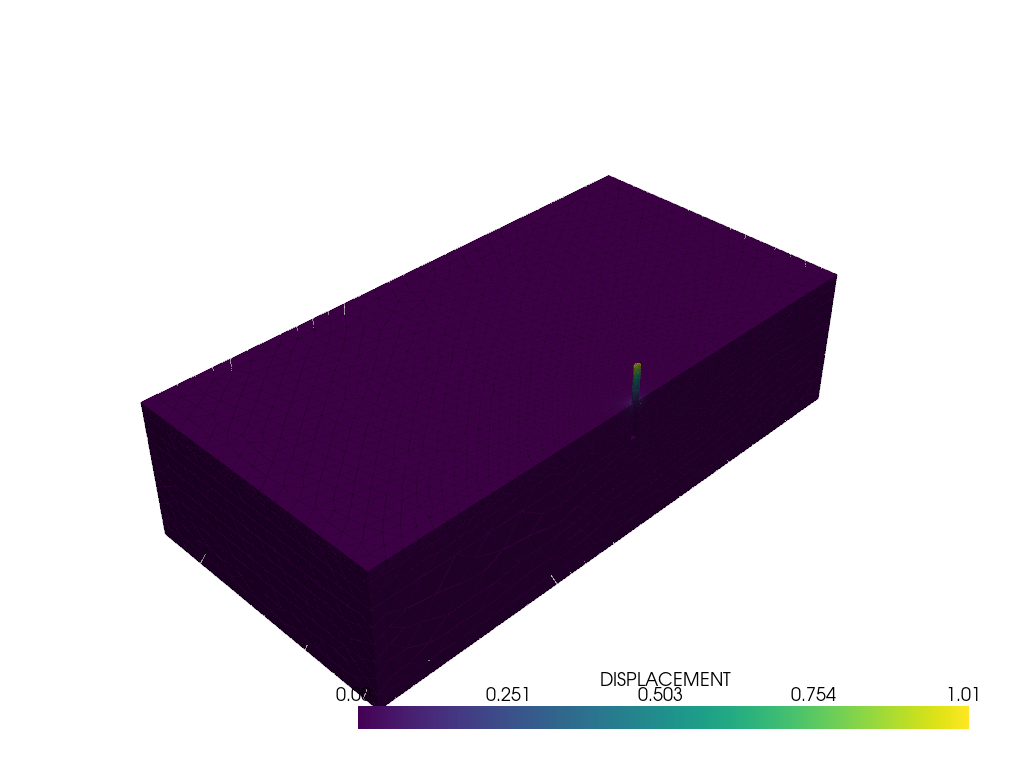

In [12]:
import pyvista as pv
pv.set_plot_theme("document")

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(1024, 768))
display.start()
vtk_files = subprocess.run(f"ls -c1 {params.data_dir}/*.vtk | sort -V", shell=True, text=True, capture_output=True)
if vtk_files.returncode == 0:
    files = [vtk_file for vtk_file in vtk_files.stdout.splitlines()]
    final_file = files[-1]
    mesh = pv.read(final_file)
    mesh=mesh.shrink(0.95) 
    warp_factor = 1.0
    # mesh = mesh.warp_by_vector(vectors="U", factor = warp_factor)
    # show_field = "STRESS"
    show_field = "DISPLACEMENT" # U: displacement
    # show_field = "STRAIN" # U: displacement
    # print(mesh.point_data)
    # if mesh.point_data[show_field].shape[1] > 3:
        # cmap = "Spectral"
    p = pv.Plotter(notebook=True)
    p.add_mesh(mesh, scalars=show_field)
    # p.camera_position = [(-10, 0, 10), (0.0, 0.0, 0.0), (0.0, 1.0, 0.0)]
    p.camera_position = 'iso'
    p.show(jupyter_backend='ipygany')

# 7. Extract data from .vtk files 
Tools:
pvpython

In [13]:
data_dir = params.data_dir
# data_dir = r"/mofem_install/jupyter/thomas/mfront_example_test/simulations/day_39_sim_3_2024_09_25_18_50_27"

!/mofem_install/jupyter/thomas/ParaView-5.13.0-RC1-MPI-Linux-Python3.10-x86_64/bin/pvpython /mofem_install/jupyter/thomas/mfront_example_test/src/paraview_pvpython.py {data_dir}

╭───────────────────────────────────╮
│  EXTRACTING GROUP DATA FROM .vtk  │
╰───────────────────────────────────╯
Read Success
Done, taken Wall Time: 726.79 seconds, CPU Time: 870.80 seconds
╭─────────────────────────────╮
│  EXTRACTING DATA FROM .vtk  │
╰─────────────────────────────╯
Read Success
Done, taken Wall Time: 11.94 seconds, CPU Time: 26.61 seconds


# 8. Plotting
Tools:
Matplotlib

In [1]:
import sys
sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')
import plotting
import custom_models as cm
data_dir = r"/mofem_install/jupyter/thomas/mfront_example_test/simulations/auto_LinearElasticity_d39_8_2024_09_25_22_16_19"
mode = "auto"
# data_dir = r"/mofem_install/jupyter/thomas/mfront_example_test/simulations/manual_LinearElasticity_d39_7_2024_09_25_20_58_41"
# mode = "manual"
soil_model = cm.PropertyTypeEnum.elastic
suptitle = f"Mesh mode: {mode} | Behaviour: {soil_model.value}"

time_plot_config = plotting.PlotConfig(
    csv_files = {
        "1.2,0,0 (Compression)": f'{data_dir}/dis_to_time_compression_mudline_1.2.csv', 
        "1.1,0,0 (Compression)": f'{data_dir}/dis_to_time_compression_mudline_1.1.csv', 
        "1.0,0,0 (Compression)": f'{data_dir}/dis_to_time_compression_mudline_1.0.csv', 
     }, 
    output_dir = data_dir,
    suptitle = suptitle,
)

depth_plot_config = plotting.PlotConfig(
    csv_files = {
        "1.2,0,0 (Compression)": f'{data_dir}/dis_to_depth_compression_x_1.2.csv', 
        "1.1,0,0 (Compression)": f'{data_dir}/dis_to_depth_compression_x_1.1.csv', 
        "1.0,0,0 (Compression)": f'{data_dir}/dis_to_depth_compression_x_1.csv', 
     }, 
    output_dir = data_dir,
    suptitle = suptitle,
)

against_time_plotter = plotting.TimePlotter(time_plot_config)
against_depth_plotter = plotting.DepthPlotter(depth_plot_config)

sigvM_e = against_time_plotter.sigvM_e(save_as="sigvM_e.png")
J_p = against_time_plotter.J_p(save_as="J_p.png")

dispx_z = against_depth_plotter.plot_displacement_vs_depth(save_as="dispx_z.png")
sigxx_z = against_depth_plotter.sigxx_z(save_as="sigxx_z.png")
sigvM_z = against_depth_plotter.plot_von_mises_vs_depth(save_as="sigvM_z.png")
E_z = against_depth_plotter.E_z(save_as="E_z.png")

╭─────────────────────────────╮
│  PLOTTING sig_vM AGAINST e  │
╰─────────────────────────────╯
Done, taken Wall Time: 0.15 seconds, CPU Time: 1.61 seconds
╭────────────────────────╮
│  PLOTTING J against p  │
╰────────────────────────╯
Done, taken Wall Time: 0.09 seconds, CPU Time: 0.09 seconds
╭─────────────────────────────╮
│  PLOTTING disp_x AGAINST z  │
╰─────────────────────────────╯
Done, taken Wall Time: 0.10 seconds, CPU Time: 0.10 seconds
╭─────────────────────────────╮
│  PLOTTING sig_xx AGAINST z  │
╰─────────────────────────────╯
Done, taken Wall Time: 0.09 seconds, CPU Time: 0.09 seconds
╭─────────────────────────────╮
│  PLOTTING sig_vM AGAINST z  │
╰─────────────────────────────╯
Done, taken Wall Time: 0.10 seconds, CPU Time: 0.10 seconds
╭────────────────────────╮
│  PLOTTING E AGAINST z  │
╰────────────────────────╯
Done, taken Wall Time: 0.11 seconds, CPU Time: 0.11 seconds


In [3]:
from IPython.display import display, HTML

# Time-related images with a common title
display(HTML('<h3 style="text-align:left">Across Time Steps</h3>'))

image_files_time = [sigvM_e, J_p]
images_html_time = ''.join([
    f'<img src="{img}" style="display:inline;margin:1px" width="300"/>'
    for img in image_files_time
])
display(HTML(images_html_time))

# Depth-related images with a common title
display(HTML('<h3 style="text-align:elft">At the Final Time Step</h3>'))

image_files_depth = [dispx_z, sigxx_z, sigvM_z, E_z]
images_html_depth = ''.join([
    f'<img src="{img}" style="display:inline;margin:1px" width="300"/>'
    for img in image_files_depth
])
display(HTML(images_html_depth))